In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


In [65]:
class MyNeuralNet(nn.Module):
    """
    Custom Neural Network with:
    - Layer 1: 3 neurons with ReLU activation
    - Layer 2: 2 neurons with Sigmoid activation
    - Combination layer: Element-wise addition + Tanh
    - Output: Single neuron (Linear)
    """
    def __init__(self, input_dim=1, hidden1_dim=3, hidden2_dim=2, output_dim=1):
        """
        Initialize the neural network layers

        Args:
            input_dim (int): Input feature dimension
            hidden1_dim (int): Number of neurons in first hidden layer
            hidden2_dim (int): Number of neurons in second hidden layer
            output_dim (int): Output dimension
        """
        super(MyNeuralNet, self).__init__()

        # Store dimensions for later use
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.output_dim = output_dim

        # ===== Layer 1: Input -> Hidden1 (ReLU) =====
        self.fc1 = nn.Linear(input_dim, hidden1_dim)

        # ===== Layer 2: Hidden1 -> Hidden2 (Sigmoid) =====
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)

        # ===== Output Layer: Combined -> Output (Linear) =====
        # The combination layer output dimension will be hidden2_dim (2 in this case)
        self.fc_out = nn.Linear(hidden2_dim, output_dim)

        # Initialize weights randomly
        self._initialize_weights()

        # Cache for storing activations
        self.activations = {}

    def _initialize_weights(self):
        """Initialize network weights with random values"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1.0)
                nn.init.normal_(m.bias, mean=0, std=1.0)

    def forward(self, x, verbose=True):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor
            verbose (bool): Whether to print intermediate values

        Returns:
            torch.Tensor: Network output
        """
        if verbose:
            print("="*60)
            print("FORWARD PASS")
            print("="*60)
            print(f"Input shape: {x.shape}")
            print(f"Input: {x}\n")

        # ---- Layer 1: ReLU Activation ----
        z1 = self.fc1(x)
        a1 = torch.relu(z1)
        self.activations['layer1'] = a1.detach()

        if verbose:
            print(f"Layer 1 (ReLU):")
            print(f"  z1 (pre-activation) = {z1}")
            print(f"  a1 (post-activation) = {a1}\n")

        # ---- Layer 2: Sigmoid Activation ----
        z2 = self.fc2(a1)
        a2 = torch.sigmoid(z2)
        self.activations['layer2'] = a2.detach()

        if verbose:
            print(f"Layer 2 (Sigmoid):")
            print(f"  z2 (pre-activation) = {z2}")
            print(f"  a2 (post-activation) = {a2}\n")

        # ---- Combination: Element-wise Addition + Tanh ----
        # Take first hidden2_dim neurons from layer1 to match layer2 dimensions
        combined = a1[:, :self.hidden2_dim] + a2
        a3 = torch.tanh(combined)
        self.activations['combined'] = a3.detach()

        if verbose:
            print(f"Combination Layer (Add + Tanh):")
            print(f"  combined (a1[:,:{self.hidden2_dim}] + a2) = {combined}")
            print(f"  a3 (tanh) = {a3}\n")

        # ---- Output Layer: Linear ----
        output = self.fc_out(a3)
        self.activations['output'] = output.detach()

        if verbose:
            print(f"Output Layer (Linear):")
            print(f"  output = {output}")
            print("="*60 + "\n")

        return output

    def visualize_activations(self):
        """Visualize activation outputs of all layers"""
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle("Neural Network Activations Visualization",
                     fontsize=16, fontweight='bold')

        # Layer 1 - ReLU
        a1 = self.activations['layer1'][0].numpy()
        axes[0].bar(range(len(a1)), a1, color='#FF6B35', edgecolor='black', linewidth=1.2)
        axes[0].set_title("Layer 1 - ReLU", fontsize=13, fontweight='bold')
        axes[0].set_xlabel("Neuron Index", fontsize=11)
        axes[0].set_ylabel("Activation Value", fontsize=11)
        axes[0].grid(axis='y', alpha=0.3)
        axes[0].axhline(0, color='red', linestyle='--', linewidth=1)

        # Layer 2 - Sigmoid
        a2 = self.activations['layer2'][0].numpy()
        axes[1].bar(range(len(a2)), a2, color='#4ECDC4', edgecolor='black', linewidth=1.2)
        axes[1].set_title("Layer 2 - Sigmoid", fontsize=13, fontweight='bold')
        axes[1].set_xlabel("Neuron Index", fontsize=11)
        axes[1].set_ylabel("Activation Value", fontsize=11)
        axes[1].grid(axis='y', alpha=0.3)
        axes[1].axhline(0.5, color='blue', linestyle='--', linewidth=1, label='0.5')
        axes[1].legend()

        # Combined - Tanh
        a3 = self.activations['combined'][0].numpy()
        axes[2].bar(range(len(a3)), a3, color='#95E1D3', edgecolor='black', linewidth=1.2)
        axes[2].set_title("Combined - Tanh", fontsize=13, fontweight='bold')
        axes[2].set_xlabel("Neuron Index", fontsize=11)
        axes[2].set_ylabel("Activation Value", fontsize=11)
        axes[2].grid(axis='y', alpha=0.3)
        axes[2].axhline(0, color='red', linestyle='--', linewidth=1)

        plt.tight_layout()
        plt.show()

    def print_gradients(self):
        """Print gradients of all trainable parameters"""
        print("\n" + "="*60)
        print("GRADIENTS")
        print("="*60)

        for name, param in self.named_parameters():
            if param.grad is not None:
                print(f"{name}:")
                print(f"  Shape: {param.grad.shape}")
                print(f"  Values:\n{param.grad}\n")
            else:
                print(f"{name}: No gradient computed\n")

        print("="*60)

    def get_model_summary(self):
        """Print model architecture summary"""
        print("\n" + "="*60)
        print("MODEL ARCHITECTURE")
        print("="*60)
        print(f"Input dimension: {self.input_dim}")
        print(f"Hidden Layer 1: {self.hidden1_dim} neurons (ReLU)")
        print(f"Hidden Layer 2: {self.hidden2_dim} neurons (Sigmoid)")
        print(f"Combination: Element-wise addition + Tanh")
        print(f"Output dimension: {self.output_dim}")

        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print(f"\nTotal Parameters: {total_params}")
        print(f"Trainable Parameters: {trainable_params}")
        print("="*60 + "\n")

In [66]:
# This cell is now empty and can be deleted or ignored.

In [67]:
# This cell is now empty and can be deleted or ignored.

In [68]:
# This cell is now empty and can be deleted or ignored.

In [69]:
# This cell is now empty and can be deleted or ignored.

In [70]:
# This cell is now empty and can be deleted or ignored.

In [71]:
# This cell is now empty and can be deleted or ignored.


 Neural Network Demo - OOP Structure


MODEL ARCHITECTURE
Input dimension: 1
Hidden Layer 1: 3 neurons (ReLU)
Hidden Layer 2: 2 neurons (Sigmoid)
Combination: Element-wise addition + Tanh
Output dimension: 1

Total Parameters: 17
Trainable Parameters: 17

 Running Forward Pass...
FORWARD PASS
Input shape: torch.Size([1, 1])
Input: tensor([[1.]], requires_grad=True)

Layer 1 (ReLU):
  z1 (pre-activation) = tensor([[-2.2597, -1.0953, -0.8238]], grad_fn=<AddmmBackward0>)
  a1 (post-activation) = tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)

Layer 2 (Sigmoid):
  z2 (pre-activation) = tensor([[ 1.7288, -1.2979]], grad_fn=<AddmmBackward0>)
  a2 (post-activation) = tensor([[0.8493, 0.2145]], grad_fn=<SigmoidBackward0>)

Combination Layer (Add + Tanh):
  combined (a1[:,:2] + a2) = tensor([[0.8493, 0.2145]], grad_fn=<AddBackward0>)
  a3 (tanh) = tensor([[0.6907, 0.2113]], grad_fn=<TanhBackward0>)

Output Layer (Linear):
  output = tensor([[-1.0836]], grad_fn=<AddmmBackward0>)

Visualizing A

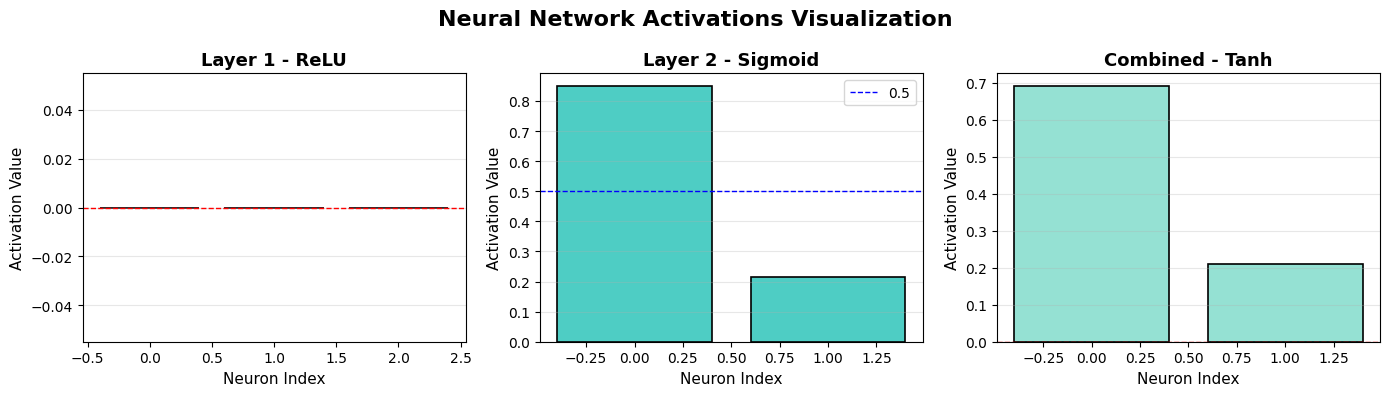

Running Backward Pass...

∂output/∂x = tensor([[0.]])


GRADIENTS
fc1.weight:
  Shape: torch.Size([3, 1])
  Values:
tensor([[0.],
        [0.],
        [0.]])

fc1.bias:
  Shape: torch.Size([3])
  Values:
tensor([0., 0., 0.])

fc2.weight:
  Shape: torch.Size([2, 3])
  Values:
tensor([[-0., -0., -0.],
        [-0., -0., -0.]])

fc2.bias:
  Shape: torch.Size([2])
  Values:
tensor([-0.0431, -0.0373])

fc_out.weight:
  Shape: torch.Size([1, 2])
  Values:
tensor([[0.6907, 0.2113]])

fc_out.bias:
  Shape: torch.Size([1])
  Values:
tensor([1.])


 Demo completed successfully!

Creating multiple network instances...


MODEL ARCHITECTURE
Input dimension: 2
Hidden Layer 1: 5 neurons (ReLU)
Hidden Layer 2: 3 neurons (Sigmoid)
Combination: Element-wise addition + Tanh
Output dimension: 1

Total Parameters: 37
Trainable Parameters: 37

 Both networks are independent instances with different architectures!


In [72]:
def main():
    """Main function to demonstrate the neural network"""

    print("\n Neural Network Demo - OOP Structure\n")

    # Create an instance of the neural network
    net = MyNeuralNet(input_dim=1, hidden1_dim=3, hidden2_dim=2, output_dim=1)

    # Print model summary
    net.get_model_summary()

    # Create input tensor
    x = torch.tensor([[1.0]], requires_grad=True)

    # Forward pass
    print(" Running Forward Pass...")
    output = net.forward(x, verbose=True)

    # Visualize activations
    print("Visualizing Activations...")
    net.visualize_activations()

    # Backward pass
    print("Running Backward Pass...")
    output.backward(torch.ones_like(output))

    # Print input gradient
    print(f"\n∂output/∂x = {x.grad}\n")

    # Print all parameter gradients
    net.print_gradients()

    print("\n Demo completed successfully!\n")

    # Demonstrate creating multiple instances
    print("Creating multiple network instances...\n")
    net2 = MyNeuralNet(input_dim=2, hidden1_dim=5, hidden2_dim=3, output_dim=1)
    net2.get_model_summary()

    print(" Both networks are independent instances with different architectures!")


if __name__ == "__main__":
    main()